## Connect to your Google drive
ignore this process if not using Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install pandas and load pre-requisites
Before running the code, change the directory to where you have located the data files

In [ ]:
# !pip install pandas==1.4.2
import os
os.chdir("/content/drive/MyDrive/PhD Work/Generative Grid Design") # change this to the directory where the data is saved
os.getcwd()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
print(pd.__version__)
import numpy as np
import matplotlib.pyplot as plt

import pickle
from os import path
import networkx as nx

1.5.3


## Load SynGrid data and save it to a pickle file for easy use
Ignore this process if it is already pickled (set load_and_save = 0)

In [ ]:
load_and_save = 0 # change this to 1 to pickle the SynGrid generated csv data (reading pickled files are much faster than csv files)
if load_and_save == 1:
  folder_path = "./dataset_37_bus/"

  # check all possible numebr of nodes in the test case
  num_nodes = set()
  for i in range(37,151):
      if path.exists(f'{folder_path}n{i}_1_gen.csv'):
          num_nodes.add(i)

  dataset_df = []

  for i in num_nodes:
      for j in range(1,1001):
          if j%100 == 0:
              print(f"Execute {j}th iter")
          branch_file_name = f"n{i}_{j}_branch.csv"
          gen_file_name = f"n{i}_{j}_gen.csv"
          bus_file_name = f"n{i}_{j}_bus.csv"

          branch_data = pd.read_csv(folder_path+branch_file_name, header = None)
          gen_data = pd.read_csv(folder_path+gen_file_name, header = None, index_col = 0)
          bus_data = pd.read_csv(folder_path+bus_file_name, header = None, index_col = 0)

          dataset_df.append([bus_data, gen_data, branch_data])

  pickle.dump(dataset_df, open("37_node_dataset_df.p", "wb"))

# Pre-processing of the raw data

In [ ]:
# load example data of 37 bus system
dataset_df = pickle.load(open("37_node_dataset_df.p", "rb"))

## Processing the MATLAB data to extract features

In [ ]:
# NOTE: the original index of nodes is starting from 1 in Matlab
dataset = []

for bus_df, gen_df, branch_df in dataset_df:
    # merge the bus and gen data since both of them contain nodal info
    merged_data = bus_df.merge(gen_df, left_index=True,
                               right_index=True, how='left')
    # only keep the useful features
    node_df = merged_data[['1_x', '2_x', '1_y', '7_y', '8_y', '8_x']]
    node_df = node_df.fillna({'1_y':0, '8_y':0}) # for non-generator nodes
    node_df = node_df.fillna({'7_y':-1}) # -1 means no generator: normal status is 0/1
    node_df.rename(columns = {'1_x':'bus_type', # 1:load, 2:gen, 3:slack, 4:isolated
                              '2_x':'real_power_demand',
                              '1_y':'real_power_output',
                              '7_y':'gen_status',
                              '8_y':'gen_capacity',
                              '8_x':'voltage_angle'}, inplace=True)
    node_df["bus_type"] = node_df["bus_type"]-1 # # 0:load, 1:gen, 2:slack, 3:isolated

    edge_index = branch_df[[0,1]]
    edge_index.rename(columns={0:"from", 1:"to"}, inplace=True)
    # edge features: resistance, reactance, line rating
    edge_attr = branch_df[[2,3,5]]
    edge_attr.rename(columns={2:"resistance", 3:"reactance", 5:"line_rating"}, inplace=True)
    # categorize the edge into low, mid, and high groups
    edge_attr["edge_type"] = pd.cut(edge_attr["line_rating"],
                                    bins=[0,400,800,float('inf')], labels=[0,1,2])
    edge_df = edge_index.merge(edge_attr, left_index=True, right_index=True, how='inner')

    dataset.append([node_df, edge_df])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_attr.rename(columns={2:"resistance", 3:"reactance", 5:"line_rating"}, inplace=True)
<ipython-input-7-8dd6d0e6ecd8>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_attr["edge_type"] = pd.cut(edge_attr["line_rating"],
<ipython-input-7-8dd6d0e6ecd8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_index.rename(columns={0:"from", 1:"to"}, inplace=True)
<ipython-input-7-8dd6d0

# Set graph parameters

In [ ]:
# Set constants for the graph
node_mapping = {0:"load_bus", 1:"gen_bus", 2:"slack_bus", 3:"isolated_bus",
                "load_bus":0, "gen_bus":1, "slack_bus":2, "isolated_bus":3}

edge_mapping = {"low":0, "mid":1, "high":2,
                0:"low", 1:"mid", 2:"high"}

NUM_NODES = 37
NODE_DIM = 4+1 # number of node type: plus one for dummy indicating empty node
EDGE_DIM = 3+1 # number of edge type: plus one for dummy indicating no edge
LATENT_DIM = 64

# Construct graphs from the dataset
### get_adj_feat: obtain adjacency matrix (edge type and connection) and feature vector (node type)
### get_graph: generate graph using the adjacency matrix and feature vector

In [ ]:
def get_adj_feat(data):
    node_df, edge_df = data
    adjacency = np.zeros((EDGE_DIM, NUM_NODES, NUM_NODES), "float32")
    features = np.zeros((NUM_NODES, NODE_DIM), "float32")

    for bus_idx in node_df.index:
        node_type = node_df.loc[bus_idx, "bus_type"]
        i = bus_idx-1 # the original test case from MATPOWER index starting from 1
        features[i] = np.eye(NODE_DIM)[node_type]

    for edge_idx in edge_df.index:
        from_bus_idx, to_bus_idx = edge_df.loc[edge_idx, "from"], edge_df.loc[edge_idx, "to"]
        edge_type = edge_df.loc[edge_idx, "edge_type"]
        i, j = from_bus_idx-1, to_bus_idx-1
        adjacency[edge_type, [i,j], [j,i]] = 1

    # Where no edge at all, add 1 to last channel (indicating "non-edge")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no node, add 1 to last column (indicating "non-bus")
    features[np.sum(features, axis=1) == 0, -1] = 1

    return adjacency, features

In [ ]:
def get_graph(adjacency, features):
    graph = nx.Graph()

    # Remove "no bus" and buses with no edge
    keep_idx = np.where(
        (np.argmax(features, axis=1) != NODE_DIM - 1) # remove isolated
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add bus to graph
    for node_idx, node_type_idx in enumerate(np.argmax(features, axis=1)):
        node_type = node_mapping[node_type_idx]
        graph.add_node(node_idx+1, node_type=node_type) # convert the node index back to starting with 1

    # Add edges between nodes in the graph; based on the upper triangles
    # of the [symmetric] adjacency matrix
    (edge_ij, node_i, node_j) = np.where(np.triu(adjacency) == 1)
    for (edge_ij, node_i, node_j) in zip(edge_ij, node_i, node_j):
        if node_i == node_j or edge_ij == EDGE_DIM - 1:
            continue
        edge_type = edge_mapping[edge_ij]
        graph.add_edge(node_i+1, node_j+1, edge_type=edge_type)

    return graph

37


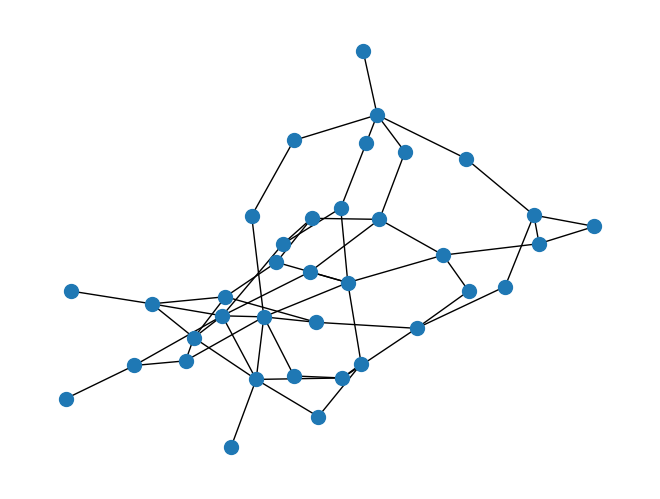

In [ ]:
# Test helper functions
adj, feats = get_adj_feat(dataset[600])
graph = get_graph(adj, feats)
nx.draw(graph, node_size=100)
print(graph.number_of_nodes())

# Create dataset in tensor from the constructed graphs

In [ ]:
adjacency_tensor, feature_tensor = [], []
for data in dataset:
    adjacency, features = get_adj_feat(data)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

# check data size
print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (1000, 4, 37, 37)
feature_tensor.shape = (1000, 37, 5)


# The graph generator module of the GAN model

In [ ]:
def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape,
):
    z = keras.layers.Input(shape=(LATENT_DIM,))
    # Propagate through one or more densely connected layers
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x) # flatten the input x
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions: because all adjacency matrices should be symmetrical
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2 # transpose the last two dimensions and add to the original, then divided it by 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")

# create generator
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(EDGE_DIM, NUM_NODES, NUM_NODES),
    feature_shape=(NUM_NODES, NODE_DIM),
)

# print generator summary
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 128)                  8320      ['input_4[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 128)                  0         ['dense_8[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 256)                  33024     ['dropout_5[0][0]']           
                                                                                          

# The GCN implementation for the descriminator in the GAN mdoel
GCN: $H^{l+1}=\sigma(D^{-1}@A@H^l@W^l)$, where $D$ is the degree matrix, $A$ is the weighted (feature induced) adjacency matrix, $W$ is the trainable weights (σ is the activation function)

In [ ]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        edge_dim = input_shape[0][1]
        node_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(edge_dim, node_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(edge_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce edge types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

# The discriminator of the GAN model

In [ ]:
def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2-D representation of graph to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # For each graph, output a single scalar value expressing the
    # "realness" of the inputted sample
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(EDGE_DIM, NUM_NODES, NUM_NODES),
    feature_shape=(NUM_NODES, NODE_DIM),
)

# print discriminator summary
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4, 37, 37)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 37, 5)]              0         []                            
                                                                                                  
 relational_graph_conv_laye  (None, 37, 128)              2560      ['input_5[0][0]',             
 r_4 (RelationalGraphConvLa                                          'input_6[0][0]']             
 yer)                                                                                             
                                                                                            

# Combine the generator and discriminator together to form the GAN model

In [ ]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs) # keras.Model.compile
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):

        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        self.batch_size = tf.shape(inputs[0])[0]

        # EM step
        # Train the discriminator for one or more steps
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        # Train the generator for one or more steps
        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

### Create GAN model and train

In [ ]:
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)

# wgan.fit([adjacency_tensor, feature_tensor], epochs=30, batch_size=1)
wgan.fit([adjacency_tensor, feature_tensor], epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 8s 22ms/step - loss_gen: 160.4749 - loss_dis: 1978.2684
Epoch 2/100
32/32 [==============================] - 1s 29ms/step - loss_gen: 181.0565 - loss_dis: -175.3725
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss_gen: 58.7628 - loss_dis: -70.6799
Epoch 4/100
32/32 [==============================] - 1s 34ms/step - loss_gen: 26.3138 - loss_dis: 132.8194
Epoch 5/100
32/32 [==============================] - 1s 35ms/step - loss_gen: 27.5988 - loss_dis: 159.7018
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss_gen: 12.9479 - loss_dis: 70.1447
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss_gen: 12.4399 - loss_dis: 30.4643
Epoch 8/100
32/32 [==============================] - 1s 20ms/step - loss_gen: 11.4784 - loss_dis: 9.1450
Epoch 9/100
32/32 [==============================] - 1s 21ms/step - loss_gen: 4.4463 - loss_dis: 6.5538
Epoch 10/100
32/32 [====================

# Generate samples using the trained generator

In [ ]:
# function for sampling new graphs
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)

    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=EDGE_DIM, axis=1)

    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))

    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=NODE_DIM, axis=2)
    return [
        get_graph(adjacency[i].numpy(), features[i].numpy())
        for i in range(batch_size)
    ]

In [ ]:
# batch_size is the number of graphs to be generated
generated_graphs = sample(wgan.generator, batch_size=100)

4/4 [==============================] - 0s 3ms/step


### Plot generated sample

0: 37
1: 37
2: 37
3: 37
4: 37
7: 37
8: 37
10: 37
12: 37
16: 37


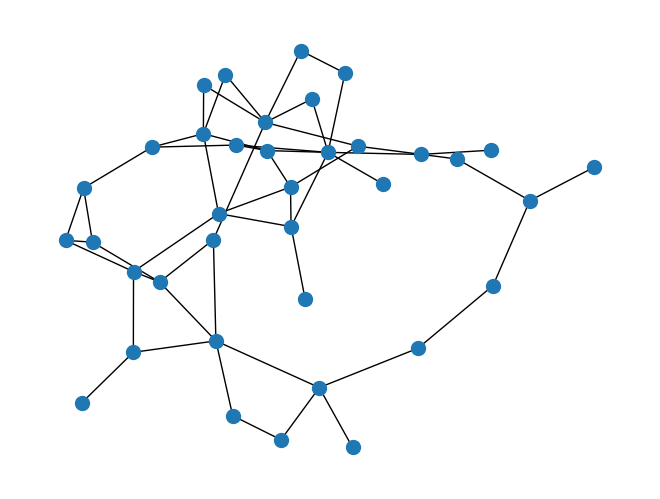

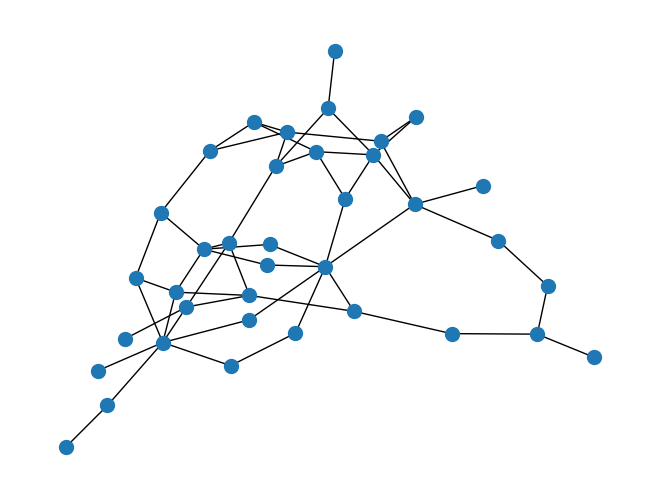

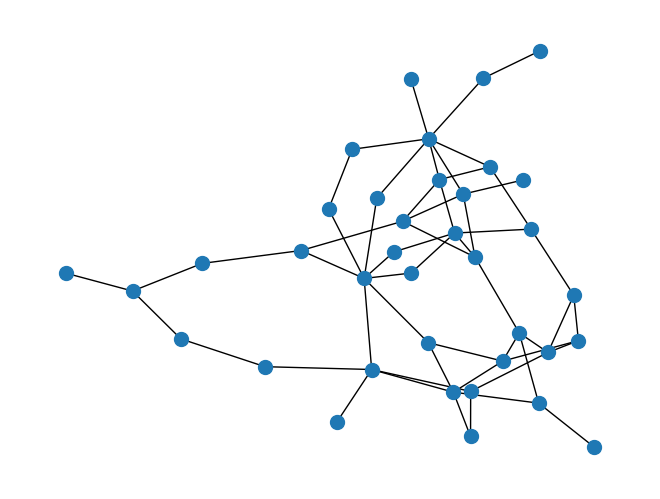

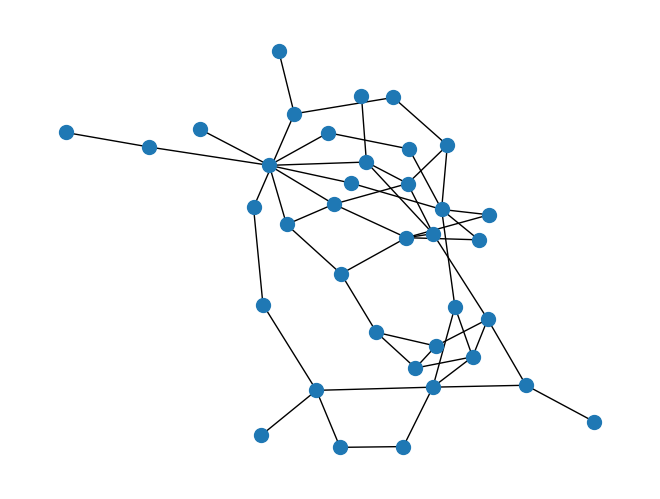

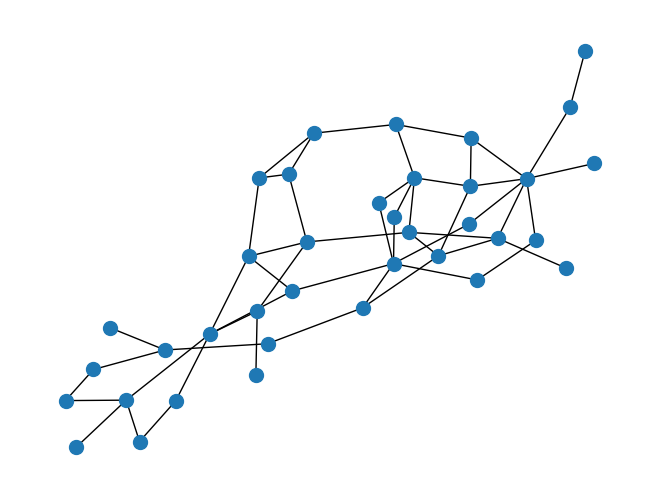

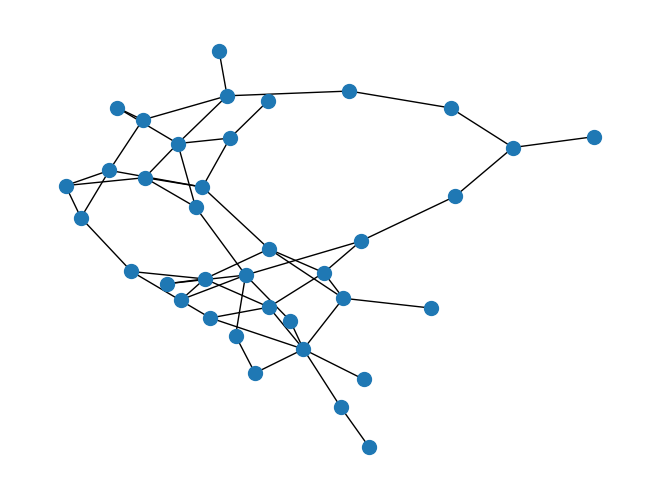

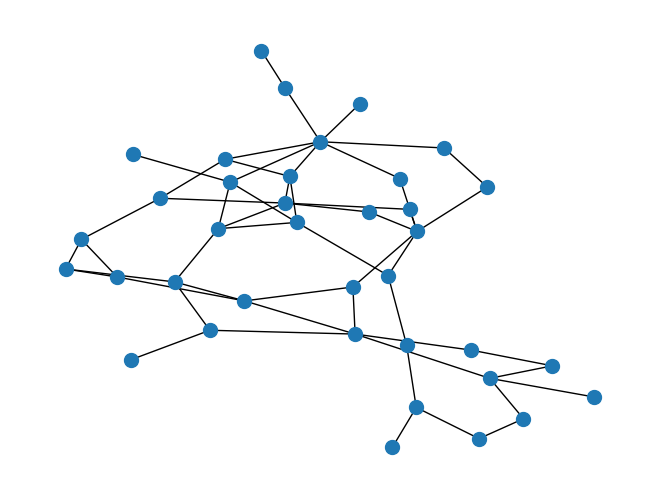

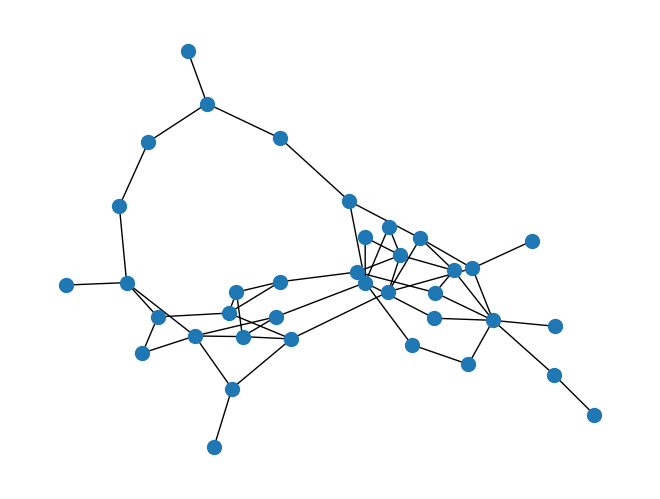

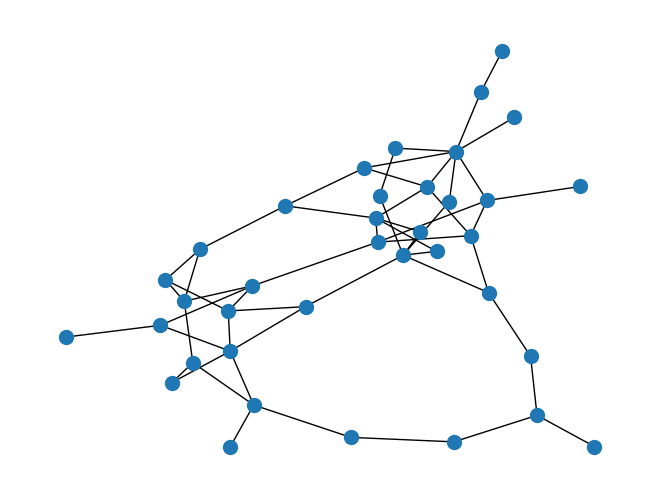

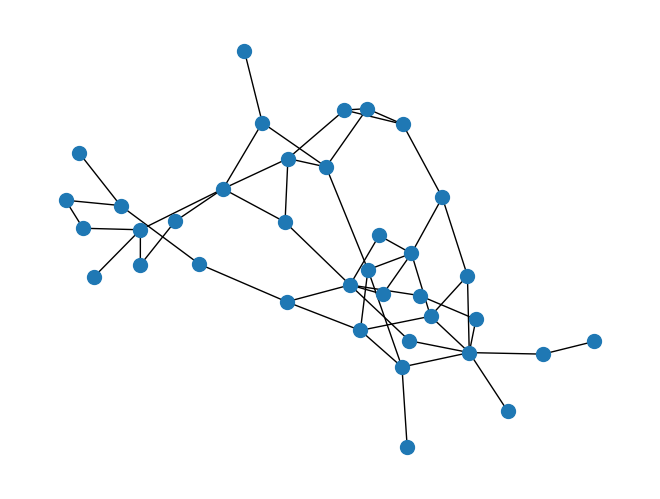

In [37]:
num_gen = 0
for ii, graph in enumerate(generated_graphs):
  if graph.number_of_nodes() == NUM_NODES:
    num_gen += 1
    print(str(ii) + ': ' + str(graph.number_of_nodes()))
    plt.figure(ii)
    nx.draw(generated_graphs[ii], node_size=100)
    if num_gen >= 10:
      break